In [38]:
import pandas as pd, numpy as np, gc

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
orig = pd.read_csv('Exam_Score_Prediction.csv')

print("train_shape:",train.shape)
print("test.shape:",test.shape)
print("orig.shape:",orig.shape)

orig

train_shape: (630000, 13)
test.shape: (270000, 12)
orig.shape: (20000, 13)


,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19997,18,other,bba,6.50,71.3,yes,5.0,good,self-study,low,easy,86.5
19996,19998,18,male,b.com,3.71,41.6,no,5.9,average,coaching,medium,moderate,60.9
19997,19999,19,other,diploma,7.88,68.2,yes,4.6,poor,group study,low,easy,64.5
19998,20000,19,male,bba,4.60,76.3,no,6.1,good,self-study,medium,moderate,79.0


In [39]:
# 今後のためにリストを作る
target = 'exam_score'
base = [col for col in train.columns if col not in ['id', target]]
categories = train.select_dtypes('object').columns.to_list()
nums = [col for col in base if col not in categories]
print(f'{len(base)} Base Features:{base}')

11 Base Features:['age', 'gender', 'course', 'study_hours', 'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality', 'study_method', 'facility_rating', 'exam_difficulty']


In [40]:
# カテゴリ列のユニーク数を見る
print(train[categories].nunique(),'\n')
train[categories].head(3)

gender             3
course             7
internet_access    2
sleep_quality      3
study_method       5
facility_rating    3
exam_difficulty    3
dtype: int64 



,gender,course,internet_access,sleep_quality,study_method,facility_rating,exam_difficulty
0,female,b.sc,no,average,online videos,low,easy
1,other,diploma,yes,poor,self-study,medium,moderate
2,female,b.sc,yes,poor,coaching,high,moderate


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100

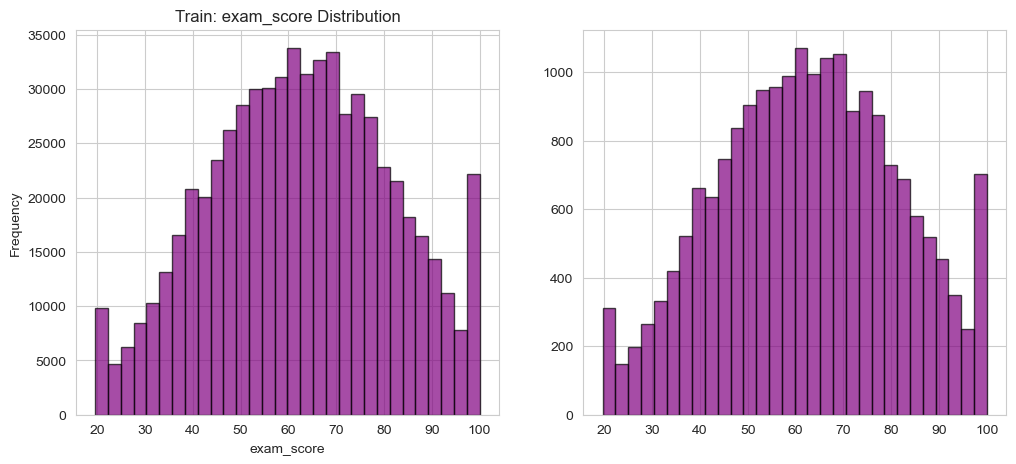

In [42]:
# trainと外部データの"目的変数の分布"の確認
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].hist(train[target], bins=30, color='purple', edgecolor='black', alpha=0.7)
ax[0].set_title(f'Train: {target} Distribution')
ax[0].set_xlabel(target)
ax[0].set_ylabel('Frequency')

if target in orig.columns:
    ax[1].hist(orig[target], bins=30, color='purple', edgecolor='black', alpha=0.7)

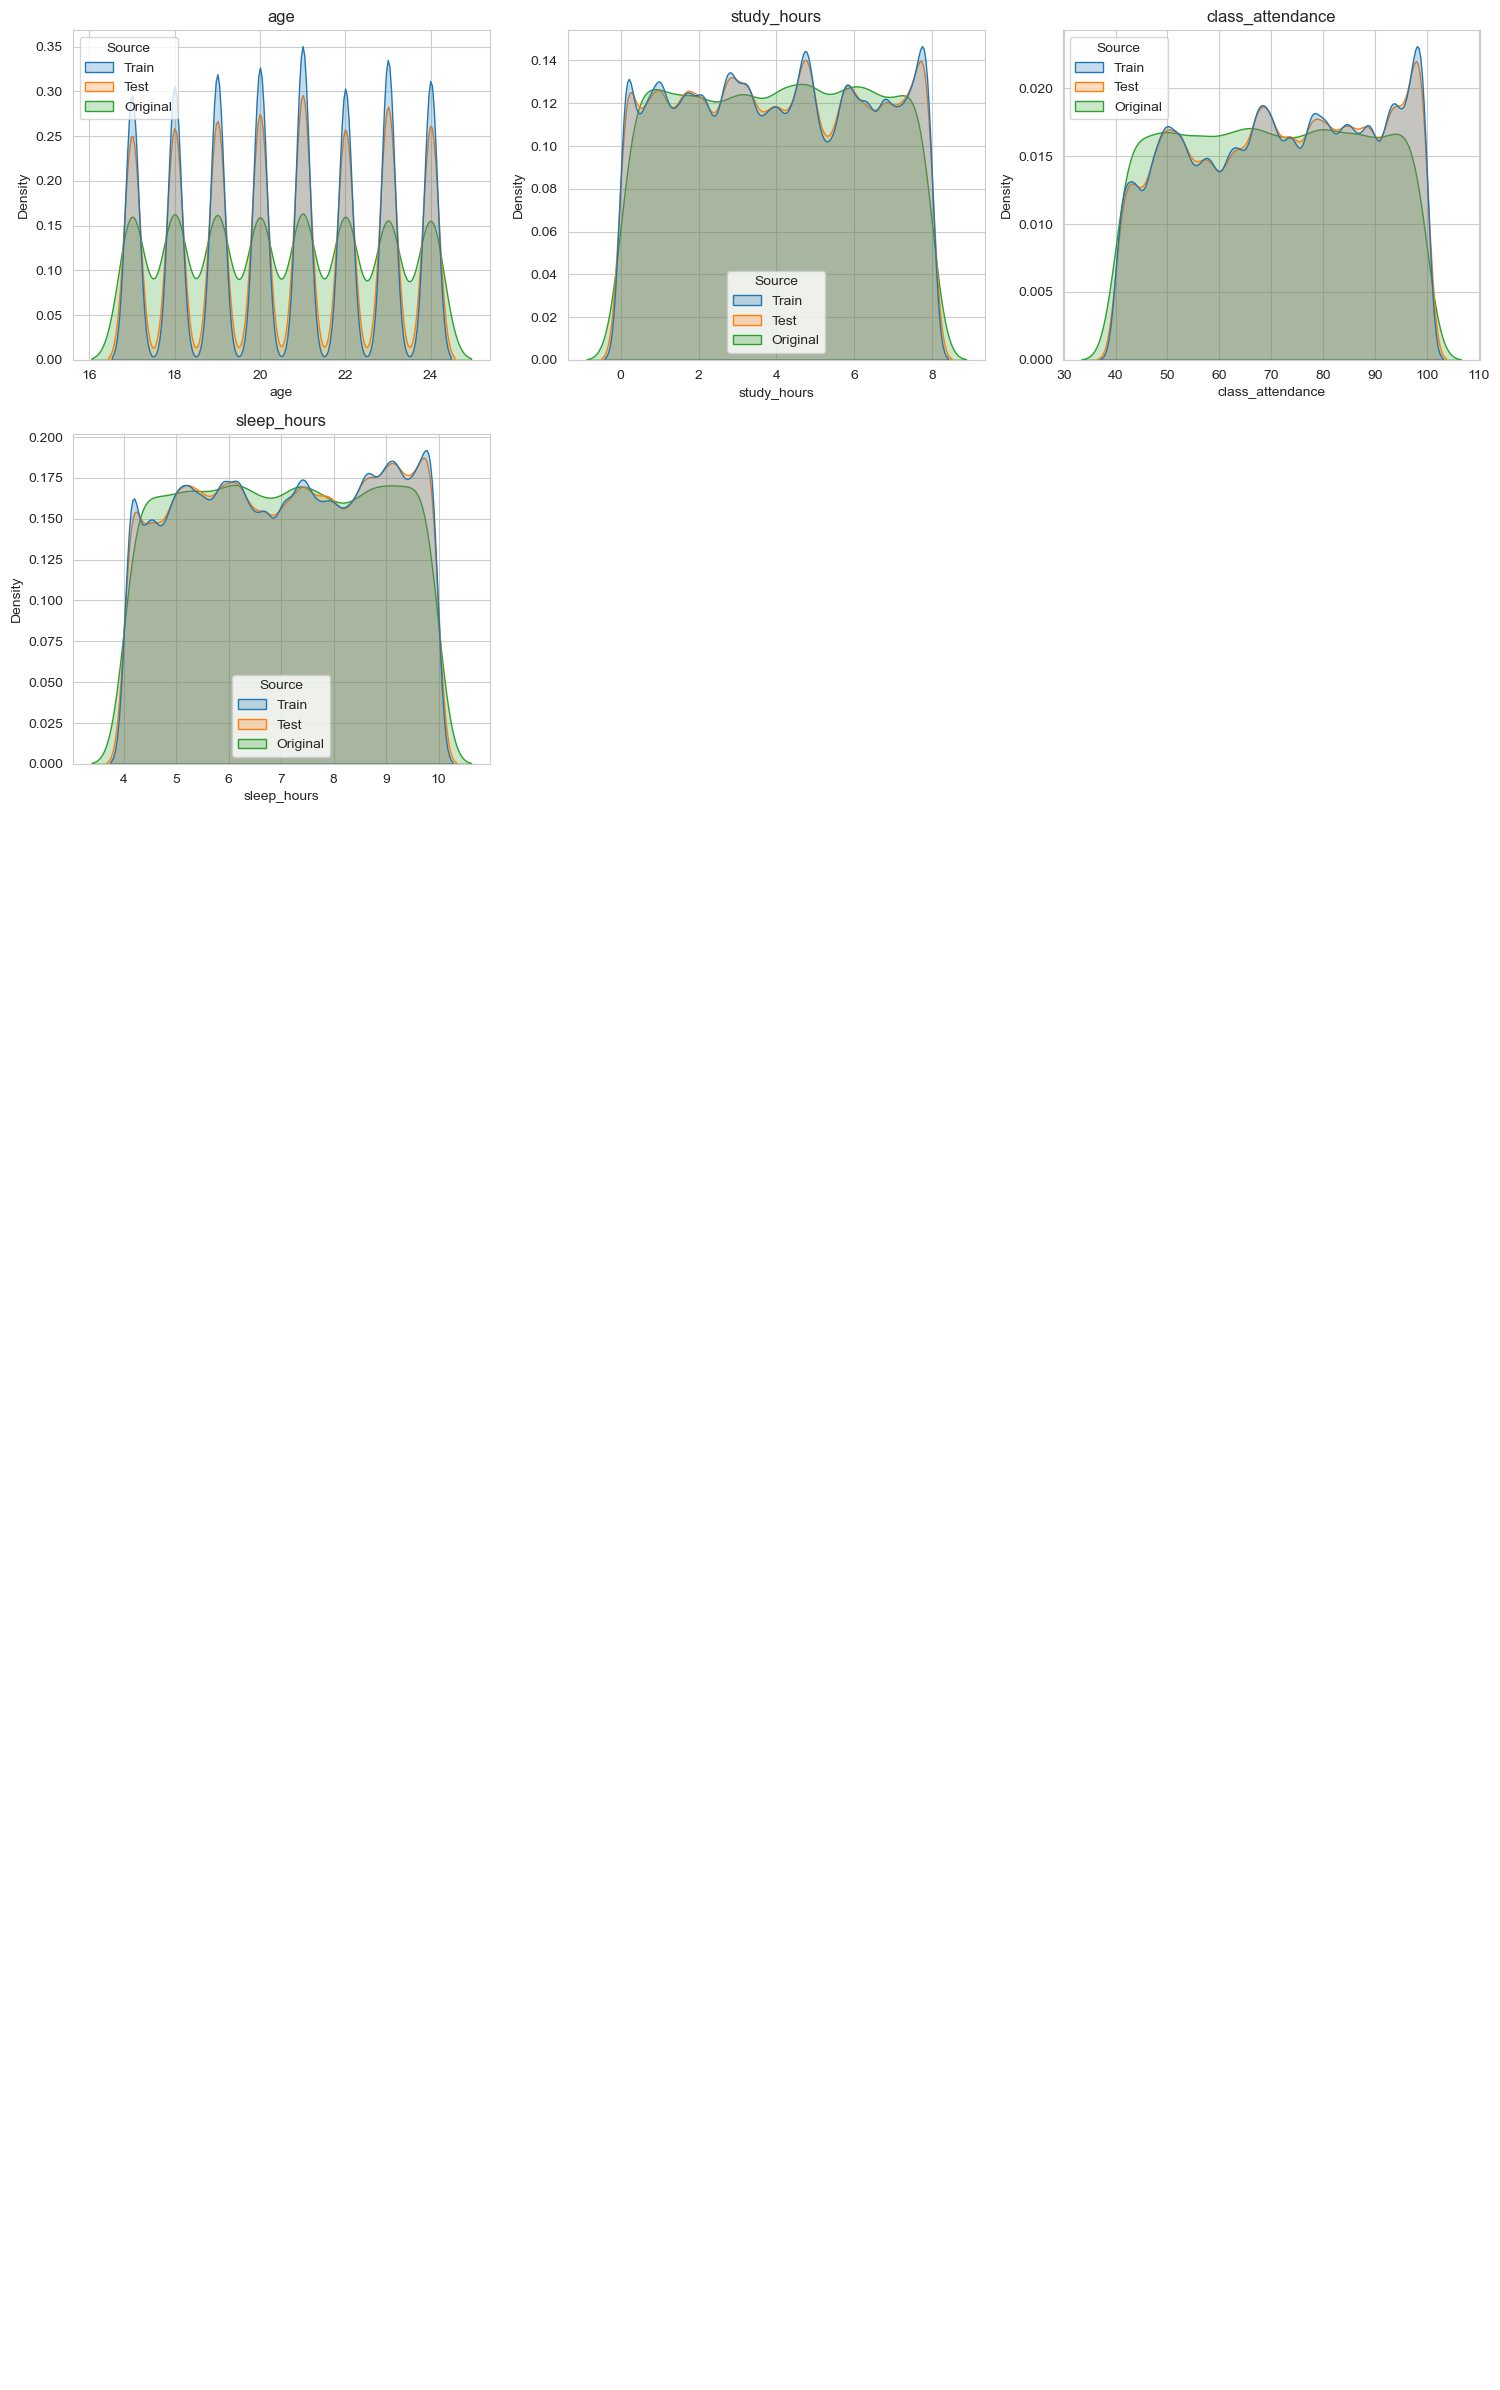

In [43]:
# カーネル密度推定によって、特徴量分布を確認する
df_plot = pd.concat([
    train[nums].assign(Source='Train'),
    test[nums].assign(Source='Test'),
    orig[nums].assign(Source='Original')
])

n_cols = 3 # 一列に並べるグラフの数
n_rows = (len(nums) + n_cols - 1) # 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(nums):
    sns.kdeplot(data=df_plot, x=col, hue='Source', ax=axes[i], 
                fill=True, common_norm=False, warn_singular=False)
    axes[i].set_title(col)

for i in range(len(nums), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

del df_plot

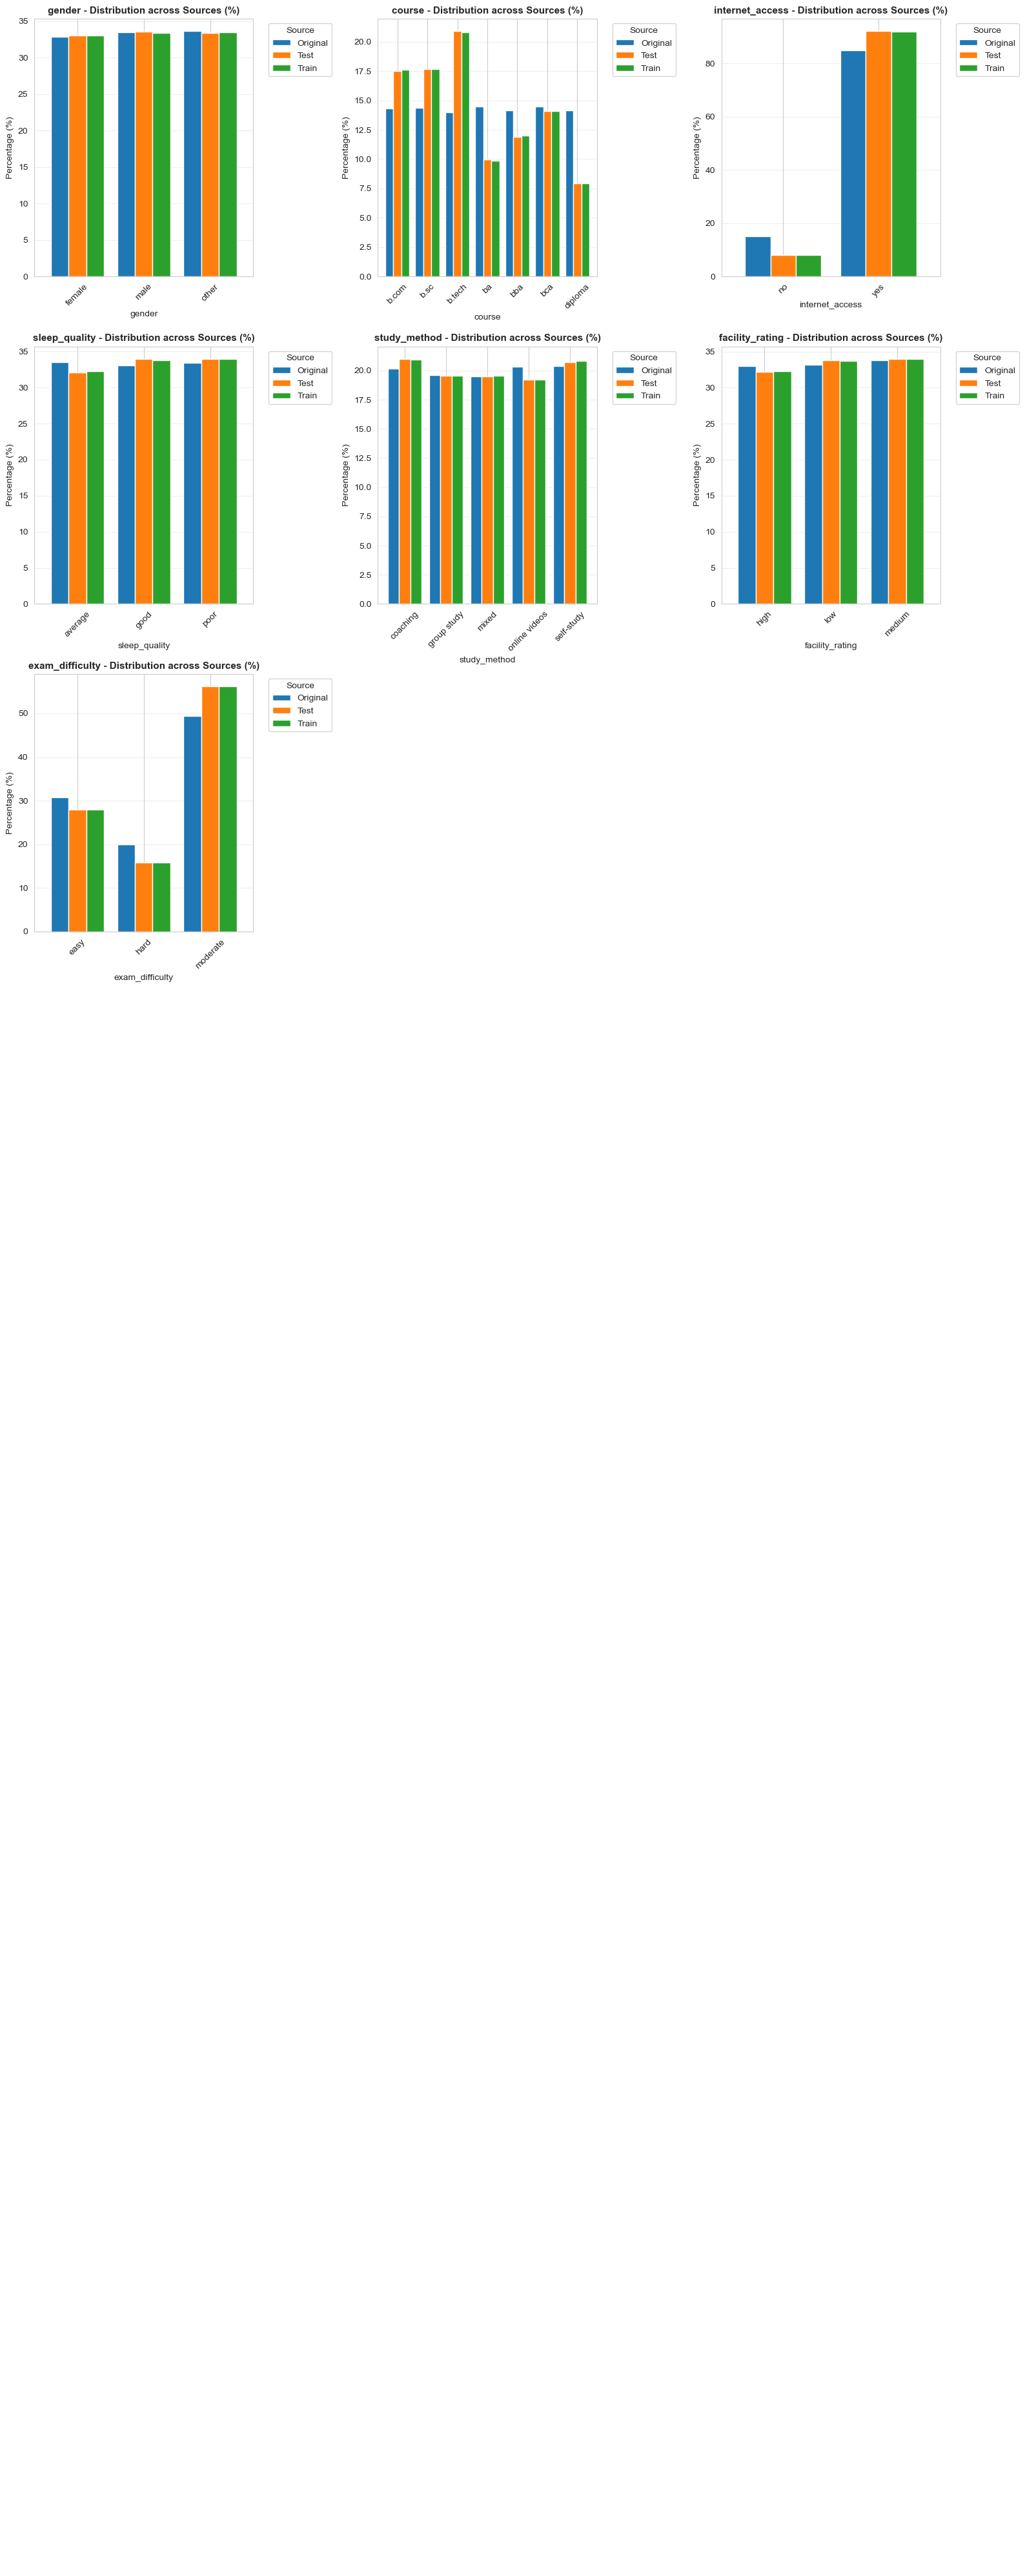

In [44]:
if len(categories) > 0:
    df_plot_categories = pd.concat([
        train[categories].assign(Source='Train'),
        test[categories].assign(Source='Test'),
        orig[categories].assign(Source='Original')
    ])
    
    n_col = 2
    n_rows = (len(categories) + n_col - 1)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
    axes = axes.flatten()

    for i, col in enumerate(categories):
        ct = pd.crosstab(df_plot_categories[col], df_plot_categories['Source'])
        ct_normalized = ct.div(ct.sum(axis=0), axis=1) * 100
        ct_normalized.plot(kind='bar', stacked=False, ax=axes[i], width=0.8)
        axes[i].set_title(f'{col} - Distribution across Sources (%)', fontsize=11, fontweight='bold')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Percentage (%)')
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
        axes[i].grid(axis='y', alpha=0.3)

    for i in range(len(categories), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    del df_plot_categories, ct, ct_normalized

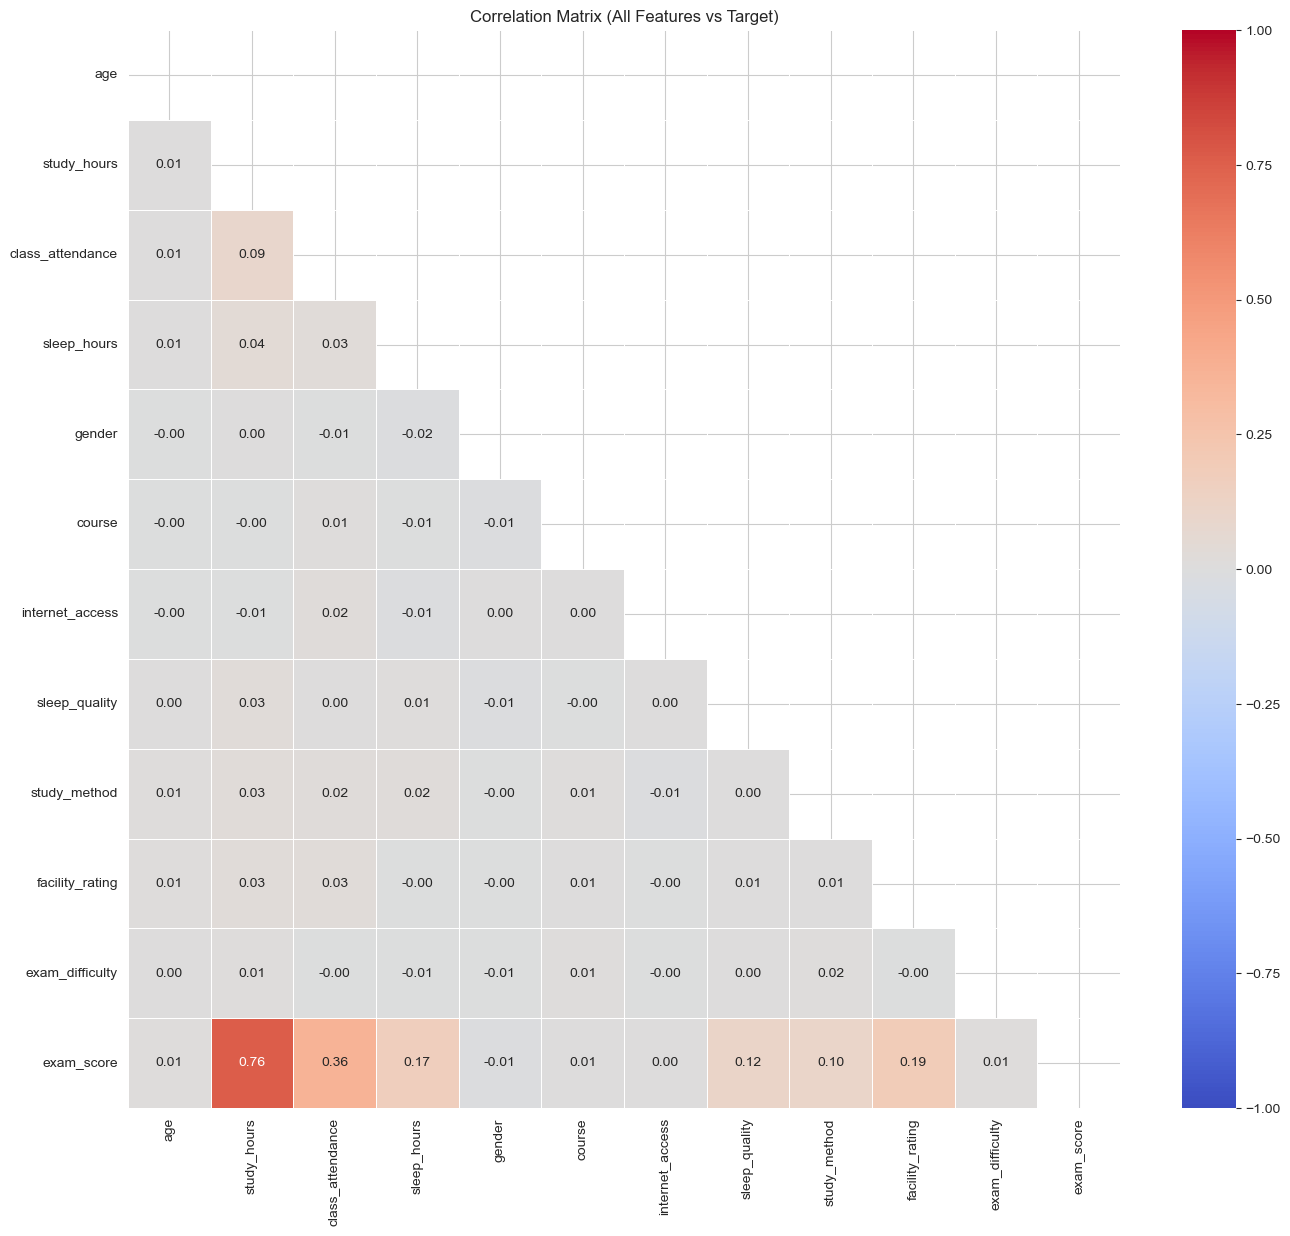

In [45]:
temp_corr_df = train[nums + categories + [target]].copy()

for col in categories:
    temp_corr_df[col] = pd.factorize(temp_corr_df[col])[0]

corr_matrix = temp_corr_df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", 
            cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix (All Features vs Target)')
plt.show()

In [46]:
ORIG = []

# 外部データの各カラムのユニークごとの平均値というカラムを追加する。
for col in base:
    # 一つの列に対してgroupbyで固有の値をまとめる。それらのtargetをそれぞれ平均する
    mean_map = orig.groupby(col)[target].mean() 
    new_mean_col_name = f"orig_mean_{col}"
    mean_map.name = new_mean_col_name
    
    train = train.merge(mean_map, on=col, how='left') # colをキーにして
    test = test.merge(mean_map, on=col, how='left')
    ORIG.append(new_mean_col_name)
    
# 外部データの各カラムのユニークごとのサイズというカラムを追加する。
    new_count_col_name = f"orig_count_{col}"
    count_map = orig.groupby(col).size().reset_index(name=new_count_col_name)
    
    train = train.merge(count_map, on=col, how='left')
    test = test.merge(count_map, on=col, how='left')
    ORIG.append(new_count_col_name)

print(f'{len(ORIG)} ORIG Features Created.')

22 ORIG Features Created.


In [47]:
# origには存在するが、trainには存在しないカテゴリを全体平均で埋める
for col in ORIG:
    if 'mean' in col:
        train[col] = train[col].fillna(orig[target].mean())
        test[col] = test[col].fillna(orig[target].mean())
    else:
        train[col] = train[col].fillna(0)
        test[col] = test[col].fillna(0)

In [48]:
# reduce_mem_usage はここに定義（そのままでOK）

features = base + ORIG

# まず X, y を作る（これが先）
X = train[features].copy()
y = train[target].copy()

# test側も、モデルに入れる列だけにそろえる（重要）
X_test = test[features].copy()

# その後にメモリ削減
X = reduce_mem_usage(X)
X_test = reduce_mem_usage(X_test)

gc.collect()


50661

In [49]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import KFold

class TargetEncoder(BaseEstimator, TransformerMixin):
    """
    Target Encoder that supports multiple aggregation functions,
    internal cross-validation for leakage prevention, and smoothing.

    Parameters
    ----------
    cols_to_encode : list of str
        List of column names to be target encoded.

    aggs : list of str, default=['mean']
        List of aggregation functions to apply. Any function accepted by
        pandas' `.agg()` method is supported, such as:
        'mean', 'std', 'var', 'min', 'max', 'skew', 'nunique', 
        'count', 'sum', 'median'.
        Smoothing is applied only to the 'mean' aggregation.

    cv : int, default=5
        Number of folds for cross-validation in fit_transform.

    smooth : float or 'auto', default='auto'
        The smoothing parameter `m`. A larger value puts more weight on the 
        global mean. If 'auto', an empirical Bayes estimate is used.
        
    drop_original : bool, default=False
        If True, the original columns to be encoded are dropped.
    """
    def __init__(self, cols_to_encode, aggs=['mean'], cv=5, smooth='auto', drop_original=False):
        self.cols_to_encode = cols_to_encode
        self.aggs = aggs
        self.cv = cv
        self.smooth = smooth
        self.drop_original = drop_original
        self.mappings_ = {}
        self.global_stats_ = {}

    def fit(self, X, y):
        """
        Learn mappings from the entire dataset.
        These mappings are used for the transform method on validation/test data.
        """
        temp_df = X.copy()
        temp_df['target'] = y

        # Learn global statistics for each aggregation
        for agg_func in self.aggs:
            self.global_stats_[agg_func] = y.agg(agg_func)

        # Learn category-specific mappings
        for col in self.cols_to_encode:
            self.mappings_[col] = {}
            for agg_func in self.aggs:
                mapping = temp_df.groupby(col)['target'].agg(agg_func)
                self.mappings_[col][agg_func] = mapping
        
        return self

    def transform(self, X):
        """
        Apply learned mappings to the data.
        Unseen categories are filled with global statistics.
        """
        X_transformed = X.copy()
        for col in self.cols_to_encode:
            for agg_func in self.aggs:
                new_col_name = f'TE_{col}_{agg_func}'
                map_series = self.mappings_[col][agg_func]
                X_transformed[new_col_name] = X[col].map(map_series)
                X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)
        
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

    def fit_transform(self, X, y):
        """
        Fit and transform the data using internal cross-validation to prevent leakage.
        """
        # First, fit on the entire dataset to get global mappings for transform method
        self.fit(X, y)

        # Initialize an empty DataFrame to store encoded features
        encoded_features = pd.DataFrame(index=X.index)
        
        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)

        for train_idx, val_idx in kf.split(X, y):
            X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
            X_val = X.iloc[val_idx]
            
            temp_df_train = X_train.copy()
            temp_df_train['target'] = y_train

            for col in self.cols_to_encode:
                # --- Calculate mappings only on the training part of the fold ---
                for agg_func in self.aggs:
                    new_col_name = f'TE_{col}_{agg_func}'
                    
                    # Calculate global stat for this fold
                    fold_global_stat = y_train.agg(agg_func)
                    
                    # Calculate category stats for this fold
                    mapping = temp_df_train.groupby(col)['target'].agg(agg_func)

                    # --- Apply smoothing only for 'mean' aggregation ---
                    if agg_func == 'mean':
                        counts = temp_df_train.groupby(col)['target'].count()
                        
                        m = self.smooth
                        if self.smooth == 'auto':
                            # Empirical Bayes smoothing
                            variance_between = mapping.var()
                            avg_variance_within = temp_df_train.groupby(col)['target'].var().mean()
                            if variance_between > 0:
                                m = avg_variance_within / variance_between
                            else:
                                m = 0  # No smoothing if no variance between groups
                        
                        # Apply smoothing formula
                        smoothed_mapping = (counts * mapping + m * fold_global_stat) / (counts + m)
                        encoded_values = X_val[col].map(smoothed_mapping)
                    else:
                        encoded_values = X_val[col].map(mapping)
                    
                    # Store encoded values for the validation fold
                    encoded_features.loc[X_val.index, new_col_name] = encoded_values.fillna(fold_global_stat)

        # Merge with original DataFrame
        X_transformed = X.copy()
        for col in encoded_features.columns:
            X_transformed[col] = encoded_features[col]
            
        if self.drop_original:
            X_transformed.drop(columns=self.cols_to_encode, inplace=True)
            
        return X_transformed

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import gc

def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and col_type.name != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    return df

X = reduce_mem_usage(X)
test = reduce_mem_usage(test)
gc.collect()

oof_preds = np.zeros(len(X))
test_preds = np.zeros(len(test))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

TE_COLS = [col for col in nums if train[col].nunique() > 2]
print(f"Target Encoding applied to {len(TE_COLS)} features.")

xgb_params = {
    'n_estimators': 20000,
    'learning_rate': 0.01,
    'max_depth': 4,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'eval_metric': 'rmse',
    'device': 'cuda',
    'enable_categorical': True,
    'early_stopping_rounds': 200
}

print(f"Starting Training...")
last_model = None
last_feature_names = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    
    X_train, y_train = X.iloc[train_idx].copy(), y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx].copy(), y.iloc[val_idx]
    X_test_fold = X_test.copy()
    
    if len(TE_COLS) > 0:
        TE = TargetEncoder(cols_to_encode=TE_COLS, cv=5, smooth='auto', aggs=['mean', 'count'], drop_original=False)
        X_train = TE.fit_transform(X_train, y_train)
        X_val = TE.transform(X_val)
        X_test_fold = TE.transform(X_test_fold)
    
    for c in categories:
        combined = pd.concat([X_train[c], X_val[c], X_test_fold[c]])
        combined_encoded, _ = combined.factorize()
        
        X_train[c] = combined_encoded[:len(X_train)]
        X_val[c] = combined_encoded[len(X_train):len(X_train)+len(X_val)]
        X_test_fold[c] = combined_encoded[len(X_train)+len(X_val):]

        X_train[c] = X_train[c].astype('category')
        X_val[c] = X_val[c].astype('category')
        X_test_fold[c] = X_test_fold[c].astype('category')

    model = XGBRegressor(**xgb_params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=500
    )
    last_model = model
    last_feature_names = X_train.columns
    
    val_preds = model.predict(X_val)
    oof_preds[val_idx] = val_preds
    test_preds += model.predict(X_test_fold) / kf.get_n_splits()
    
    fold_score = np.sqrt(mean_squared_error(y_val, val_preds))
    print(f"Fold {fold+1} RMSE: {fold_score:.5f}")

    if len(TE_COLS) > 0: del TE
    gc.collect()

print("-" * 30)
print(f"OOF RMSE: {np.sqrt(mean_squared_error(y, oof_preds)):.5f}")

Target Encoding applied to 4 features.
Starting Training...


C:\Users\ohtak\AppData\Local\Temp\ipykernel_34500\2034908936.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)
C:\Users\ohtak\AppData\Local\Temp\ipykernel_34500\2034908936.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

[0]	validation_0-rmse:18.73590


c:\Users\ohtak\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:16:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
c:\Users\ohtak\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:16:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[500]	validation_0-rmse:8.88555
[1000]	validation_0-rmse:8.78059
[1500]	validation_0-rmse:8.75587
[2000]	validation_0-rmse:8.74136
[2500]	validation_0-rmse:8.73284
[3000]	validation_0-rmse:8.72658
[3500]	validation_0-rmse:8.72194
[4000]	validation_0-rmse:8.71859
[4500]	validation_0-rmse:8.71606
[5000]	validation_0-rmse:8.71366
[5500]	validation_0-rmse:8.71131
[6000]	validation_0-rmse:8.70989
[6500]	validation_0-rmse:8.70895
[7000]	validation_0-rmse:8.70780
[7500]	validation_0-rmse:8.70700
[8000]	validation_0-rmse:8.70617
[8500]	validation_0-rmse:8.70551
[9000]	validation_0-rmse:8.70482
[9500]	validation_0-rmse:8.70443
[10000]	validation_0-rmse:8.70403
[10500]	validation_0-rmse:8.70367
[11000]	validation_0-rmse:8.70345
[11500]	validation_0-rmse:8.70327
[11522]	validation_0-rmse:8.70324
Fold 1 RMSE: 8.70320


C:\Users\ohtak\AppData\Local\Temp\ipykernel_34500\2034908936.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)
C:\Users\ohtak\AppData\Local\Temp\ipykernel_34500\2034908936.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

[0]	validation_0-rmse:18.77971


c:\Users\ohtak\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:20:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
c:\Users\ohtak\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:20:57] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[500]	validation_0-rmse:8.89477
[1000]	validation_0-rmse:8.79233
[1500]	validation_0-rmse:8.76566
[2000]	validation_0-rmse:8.75067
[2500]	validation_0-rmse:8.74138
[3000]	validation_0-rmse:8.73532
[3500]	validation_0-rmse:8.73128
[4000]	validation_0-rmse:8.72777
[4500]	validation_0-rmse:8.72519
[5000]	validation_0-rmse:8.72323
[5500]	validation_0-rmse:8.72112
[6000]	validation_0-rmse:8.71949
[6500]	validation_0-rmse:8.71821
[7000]	validation_0-rmse:8.71721
[7500]	validation_0-rmse:8.71595
[8000]	validation_0-rmse:8.71506
[8500]	validation_0-rmse:8.71460
[9000]	validation_0-rmse:8.71412
[9312]	validation_0-rmse:8.71409
Fold 2 RMSE: 8.71395


C:\Users\ohtak\AppData\Local\Temp\ipykernel_34500\2034908936.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)
C:\Users\ohtak\AppData\Local\Temp\ipykernel_34500\2034908936.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

[0]	validation_0-rmse:18.78511


c:\Users\ohtak\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:24:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
c:\Users\ohtak\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:24:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[500]	validation_0-rmse:8.88314
[1000]	validation_0-rmse:8.77869
[1500]	validation_0-rmse:8.75410
[2000]	validation_0-rmse:8.74012
[2500]	validation_0-rmse:8.73169
[3000]	validation_0-rmse:8.72544
[3500]	validation_0-rmse:8.72051
[4000]	validation_0-rmse:8.71709
[4500]	validation_0-rmse:8.71426
[5000]	validation_0-rmse:8.71171
[5500]	validation_0-rmse:8.70961
[6000]	validation_0-rmse:8.70818
[6500]	validation_0-rmse:8.70663
[7000]	validation_0-rmse:8.70545
[7500]	validation_0-rmse:8.70451
[8000]	validation_0-rmse:8.70394
[8500]	validation_0-rmse:8.70313
[9000]	validation_0-rmse:8.70253
[9500]	validation_0-rmse:8.70191
[10000]	validation_0-rmse:8.70142
[10500]	validation_0-rmse:8.70116
[11000]	validation_0-rmse:8.70094
[11445]	validation_0-rmse:8.70095
Fold 3 RMSE: 8.70077


C:\Users\ohtak\AppData\Local\Temp\ipykernel_34500\2034908936.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)
C:\Users\ohtak\AppData\Local\Temp\ipykernel_34500\2034908936.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

[0]	validation_0-rmse:18.84522


c:\Users\ohtak\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:29:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
c:\Users\ohtak\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:29:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[500]	validation_0-rmse:8.91237
[1000]	validation_0-rmse:8.80217
[1500]	validation_0-rmse:8.77496
[2000]	validation_0-rmse:8.75906
[2500]	validation_0-rmse:8.74940
[3000]	validation_0-rmse:8.74261
[3500]	validation_0-rmse:8.73769
[4000]	validation_0-rmse:8.73354
[4500]	validation_0-rmse:8.73016
[5000]	validation_0-rmse:8.72739
[5500]	validation_0-rmse:8.72510
[6000]	validation_0-rmse:8.72320
[6500]	validation_0-rmse:8.72171
[7000]	validation_0-rmse:8.72032
[7500]	validation_0-rmse:8.71905
[8000]	validation_0-rmse:8.71817
[8500]	validation_0-rmse:8.71725
[9000]	validation_0-rmse:8.71667
[9404]	validation_0-rmse:8.71644
Fold 4 RMSE: 8.71623


C:\Users\ohtak\AppData\Local\Temp\ipykernel_34500\2034908936.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_transformed[new_col_name].fillna(self.global_stats_[agg_func], inplace=True)
C:\Users\ohtak\AppData\Local\Temp\ipykernel_34500\2034908936.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

[0]	validation_0-rmse:18.82202


c:\Users\ohtak\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:32:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:49: No visible GPU is found, setting device to CPU.
  self.starting_round = model.num_boosted_rounds()
c:\Users\ohtak\anaconda3\Lib\site-packages\xgboost\callback.py:386: UserWarning: [21:32:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[500]	validation_0-rmse:8.92444
[1000]	validation_0-rmse:8.81283
[1500]	validation_0-rmse:8.78706
[2000]	validation_0-rmse:8.77274
[2500]	validation_0-rmse:8.76350
[3000]	validation_0-rmse:8.75712
[3500]	validation_0-rmse:8.75258
[4000]	validation_0-rmse:8.74848
[4500]	validation_0-rmse:8.74554
[5000]	validation_0-rmse:8.74325
[5500]	validation_0-rmse:8.74107
[6000]	validation_0-rmse:8.73929
[6500]	validation_0-rmse:8.73802
[7000]	validation_0-rmse:8.73713
[7500]	validation_0-rmse:8.73605
[8000]	validation_0-rmse:8.73518
[8500]	validation_0-rmse:8.73465
[9000]	validation_0-rmse:8.73416
[9500]	validation_0-rmse:8.73359
[9646]	validation_0-rmse:8.73362
Fold 5 RMSE: 8.73353
------------------------------
OOF RMSE: 8.71354


C:\Users\ohtak\AppData\Local\Temp\ipykernel_34500\1930905952.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df.head(40), x='Importance', y='Feature', palette='viridis')


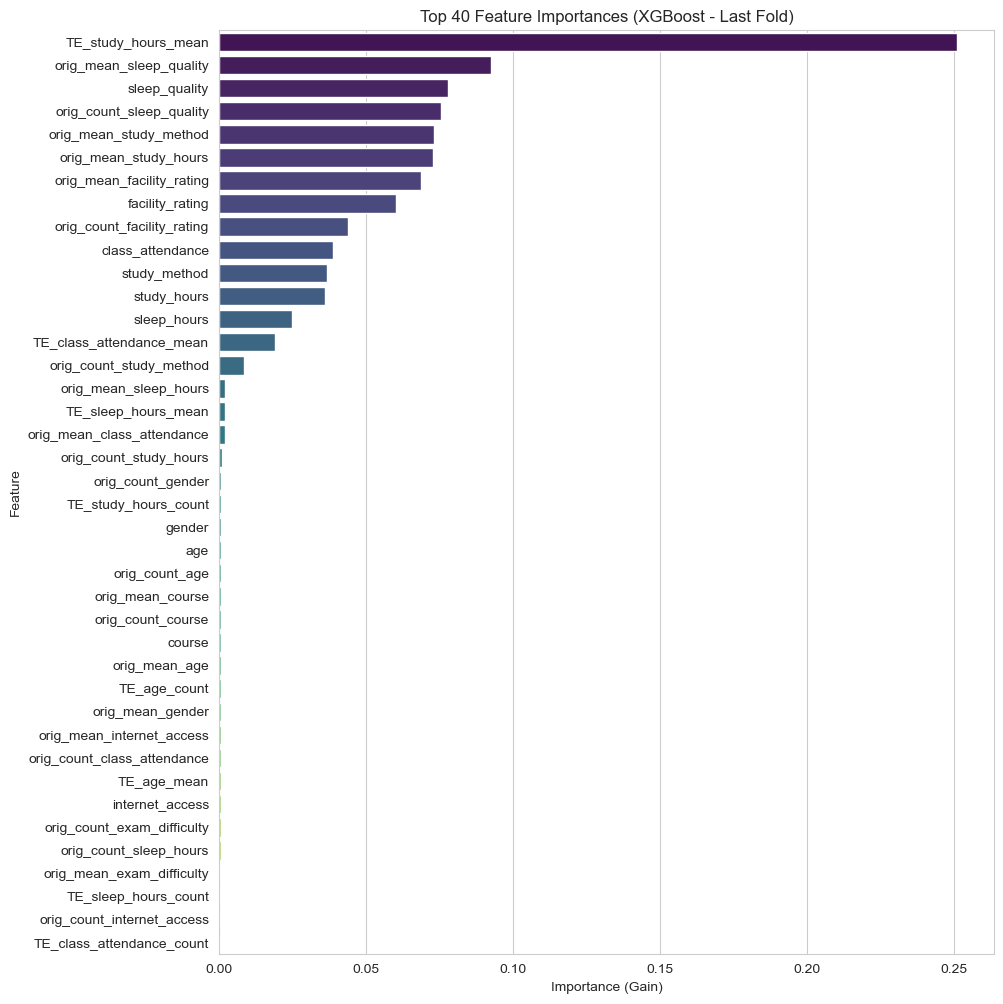

In [53]:
# Extract importances from the last trained model
# (Note: Ideally we average importances across all folds, but the last fold serves as a good proxy for a baseline)
imp_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 12))
sns.barplot(data=imp_df.head(40), x='Importance', y='Feature', palette='viridis')
plt.title('Top 40 Feature Importances (XGBoost - Last Fold)')
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.show()

Submission and OOF files saved successfully.
Submission Shape: (270000, 2)


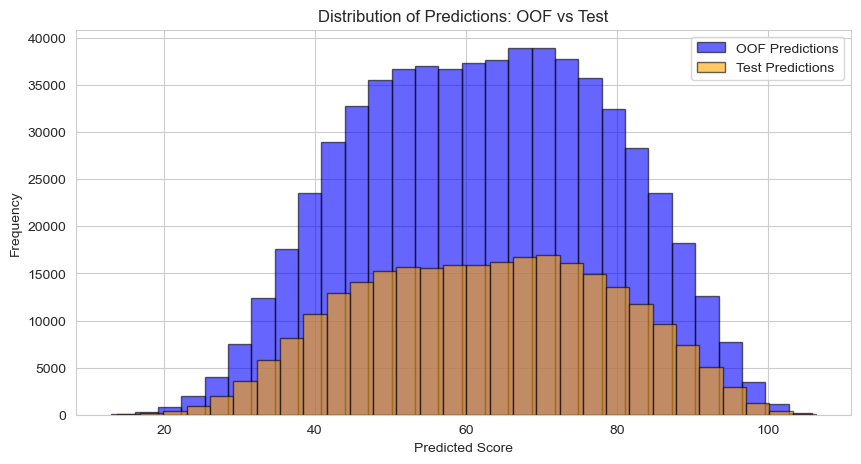

,id,exam_score
0,630000,70.101484
1,630001,68.807931
2,630002,89.456358
3,630003,55.291526
4,630004,45.365058


In [52]:
sub = pd.read_csv('sample_submission.csv')
sub[target] = test_preds
sub.to_csv('submission.csv', index=False)

oof_df = pd.DataFrame()
oof_df['id'] = train['id']
oof_df[target] = y
oof_df['pred'] = oof_preds
oof_df.to_csv('oof_predictions.csv', index=False)

print('Submission and OOF files saved successfully.')
print(f'Submission Shape: {sub.shape}')

plt.figure(figsize=(10, 5))
plt.hist(oof_df['pred'], bins=30, alpha=0.6, label='OOF Predictions', color='blue', edgecolor='black')
plt.hist(sub[target], bins=30, alpha=0.6, label='Test Predictions', color='orange', edgecolor='black')
plt.title('Distribution of Predictions: OOF vs Test')
plt.xlabel('Predicted Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

sub.head()